In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import matplotlib
matplotlib.rcParams['axes.unicode_minus']=False
import seaborn as sns
sns.set(font= "Kaiti",style="ticks",font_scale=1.4)
import pandas as pd
pd.set_option("max_colwidth", 200)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder,label_binarize
from sklearn.model_selection import  train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *

import warnings
warnings.filterwarnings("ignore")
import scanpy as sc
import anndata as ad
import torch
import sys
sys.path.append('..')
from VAE.VAE_model import VAE

In [ ]:
def load_VAE():
    autoencoder = VAE(
        num_genes=27281,
        device='cuda',
        seed=0,
        loss_ae='mse',
        hidden_dim=128,
        decoder_activation='ReLU',
    )
    # autoencoder.load_state_dict(torch.load('/data1/lep/Workspace/guided-diffusion/VAE/checkpoint/v5/model_seed=0_step=799999.pt'))
    autoencoder.load_state_dict(torch.load('/data1/lep/Workspace/guided-diffusion/VAE/checkpoint_nodrop/lung_scimilarity_lognorm_finetune_nodrop/model_seed=0_step=150000.pt'))
    return autoencoder

real data

In [18]:
adata = sc.read_h5ad('../data/Human_PF_Lung/human_lung.h5ad')
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.filter_cells(adata, min_genes=10)
adata.var_names_make_unique()
print(adata)

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

cell_data = adata.X.toarray()[::5]

cell_data.shape

AnnData object with n_obs × n_vars = 114396 × 27281
    obs: 'barcodes', 'celltype', 'n_genes', 'status'
    var: 'n_cells'


(22880, 27281)

generated data

In [5]:
npzfile=np.load('../output/lung_scimilarity.npz',allow_pickle=True)
cell_gen_all = npzfile['cell_gen'][:22000]#.squeeze(1)
print(cell_gen_all.shape)


autoencoder = load_VAE()
cell_gen_all = autoencoder(torch.tensor(cell_gen_all).cuda(),return_decoded=True).cpu().detach().numpy()#[:11400]
ori = ad.AnnData(cell_gen_all, dtype=np.float32)

cell_gen = ori.X#[:3000]
cell_gen.shape

(22000, 128)


(22000, 27281)

In [20]:
# back to anndata
full_data = np.concatenate((cell_data, cell_gen),axis=0)
full_data = ad.AnnData(full_data, dtype=np.float32)
full_data.obs_names = [f"true_Cell" for i in range(cell_data.shape[0])]+[f"gen_Cell" for i in range(cell_gen.shape[0])]

In [21]:
adata = full_data
sc.tl.pca(adata, svd_solver='arpack')# svd_solver 

In [22]:
real = adata[adata.obs_names=='true_Cell'].obsm['X_pca']
sim = adata[adata.obs_names=='gen_Cell'].obsm['X_pca']

data = np.concatenate((real,sim),axis=0)
label = np.concatenate((np.ones((real.shape[0])),np.zeros((sim.shape[0]))))

print(data.shape, label.shape)
##split the data
X_train,X_val,y_train,y_val = train_test_split(data, label,
                                               test_size = 0.25,random_state = 1)

print("X_train.shape :",X_train.shape)
print("X_val.shape :",X_val.shape)

(44880, 50) (44880,)
X_train.shape : (33660, 50)
X_val.shape : (11220, 50)


In [ ]:
## use random forest to classify the real data and generated data
rfc1 = RandomForestClassifier(n_estimators = 1000, 
                              max_depth= 5,      
                              oob_score=True,
                              class_weight = "balanced",
                              random_state=1)
rfc1.fit(X_train,y_train)
## accuracy
rfc1_lab = rfc1.predict(X_train)
rfc1_pre = rfc1.predict(X_val)
print("OOB score of random forest:",rfc1.oob_score_)
print("accuracy in training set:",accuracy_score(y_train,rfc1_lab))
print("accuracy in validation set:",accuracy_score(y_val,rfc1_pre))

plot ROC curve

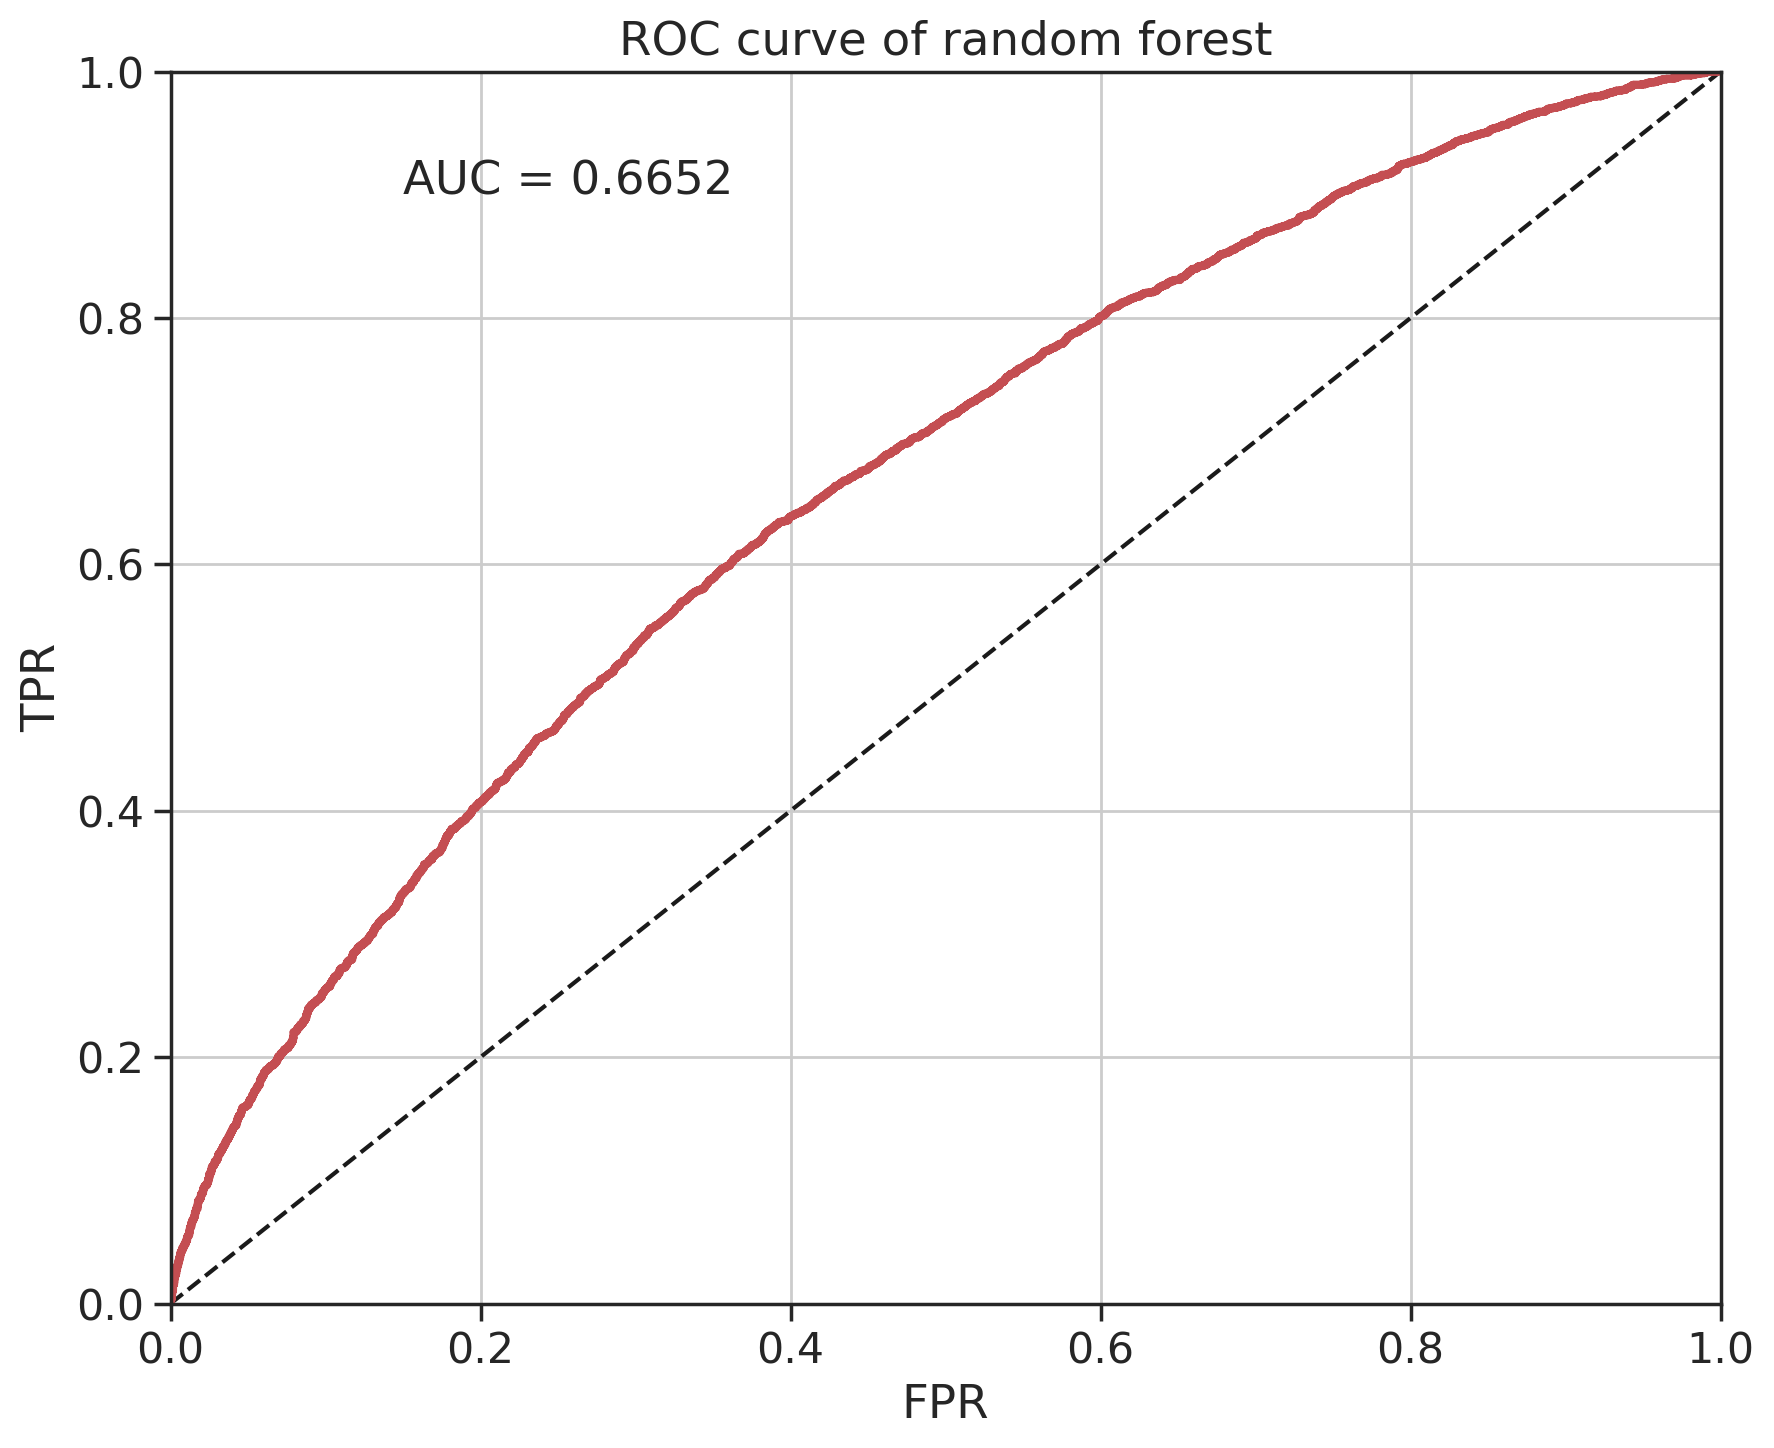

In [11]:
pre_y = rfc1.predict_proba(X_val)[:, 1]
fpr_Nb, tpr_Nb, _ = roc_curve(y_val, pre_y)
aucval = auc(fpr_Nb, tpr_Nb)    # 计算auc的取值
plt.figure(figsize=(10,8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_Nb, tpr_Nb,"r",linewidth = 3)
plt.grid()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title("ROC curve of random forest")
plt.text(0.15,0.9,"AUC = "+str(round(aucval,4)))
plt.show()